<a href="https://colab.research.google.com/github/AjayKumar1994/Stock-Price-Prediction-LSTM/blob/master/Copy_of_Stock_Price_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction of Apple

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


 **Get the data**





In [ ]:
## Get the APPLE stock data
import pandas_datareader.data as web
import datetime    

start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2020, 6, 22)
df = web.DataReader("AAPL", 'yahoo', start, end)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


In [ ]:
df.shape

(2131, 6)

In [ ]:
# Check data types in columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2131 entries, 2012-01-03 to 2020-06-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2131 non-null   float64
 1   Low        2131 non-null   float64
 2   Open       2131 non-null   float64
 3   Close      2131 non-null   float64
 4   Volume     2131 non-null   float64
 5   Adj Close  2131 non-null   float64
dtypes: float64(6)
memory usage: 116.5 KB


In [ ]:
df.isnull().values.any()  # is there any NULL variable in the dataset?

False

In [ ]:
df.describe().round(4)  

,High,Low,Open,Close,Volume,Adj Close
count,2131.0000,2131.0000,2131.0000,2131.0000,2.131000e+03,2131.0000
mean,137.6918,135.0822,136.3543,136.4450,5.856654e+07,129.7785
std,64.2179,62.7462,63.3638,63.5812,4.588330e+07,65.9561
min,57.0857,55.0143,55.4243,55.7900,1.136200e+07,49.0101
25%,88.5800,86.6093,87.9657,87.7157,2.771435e+07,76.8070
50%,116.7500,114.8500,115.9300,115.6200,4.230720e+07,107.7701
75%,174.9950,172.2250,173.6500,174.0300,7.253715e+07,168.3831
max,359.4600,351.1500,355.1500,358.8700,3.765300e+08,358.8700


In [ ]:
# Display features in data set
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

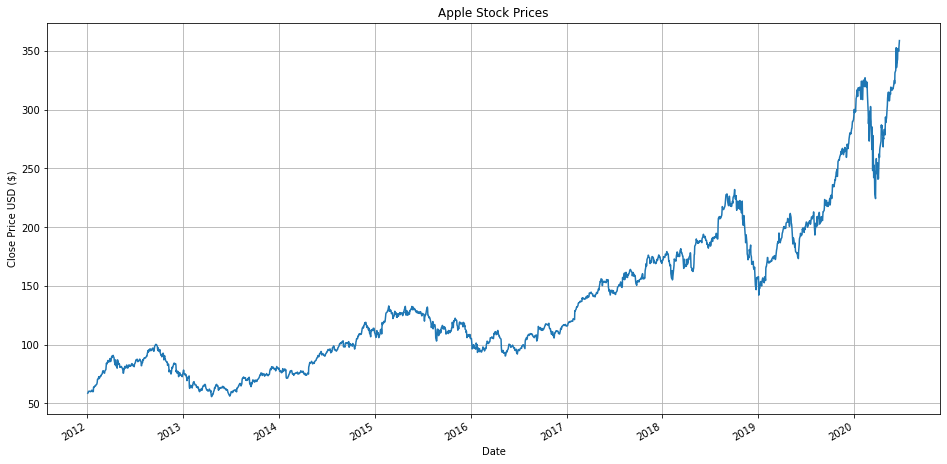

In [ ]:
#Visualize the close price data
plt.figure(figsize=(16,8))
plt.title('Apple Stock Prices')
plt.xlabel('Years')
plt.ylabel('Close Price USD ($)')
df['Close'].plot()
plt.grid()
plt.show()

**Correlation Analysis**

In [ ]:
X=df.drop(['Close'],axis=1)
X=X.drop(['Adj Close'],axis=1)

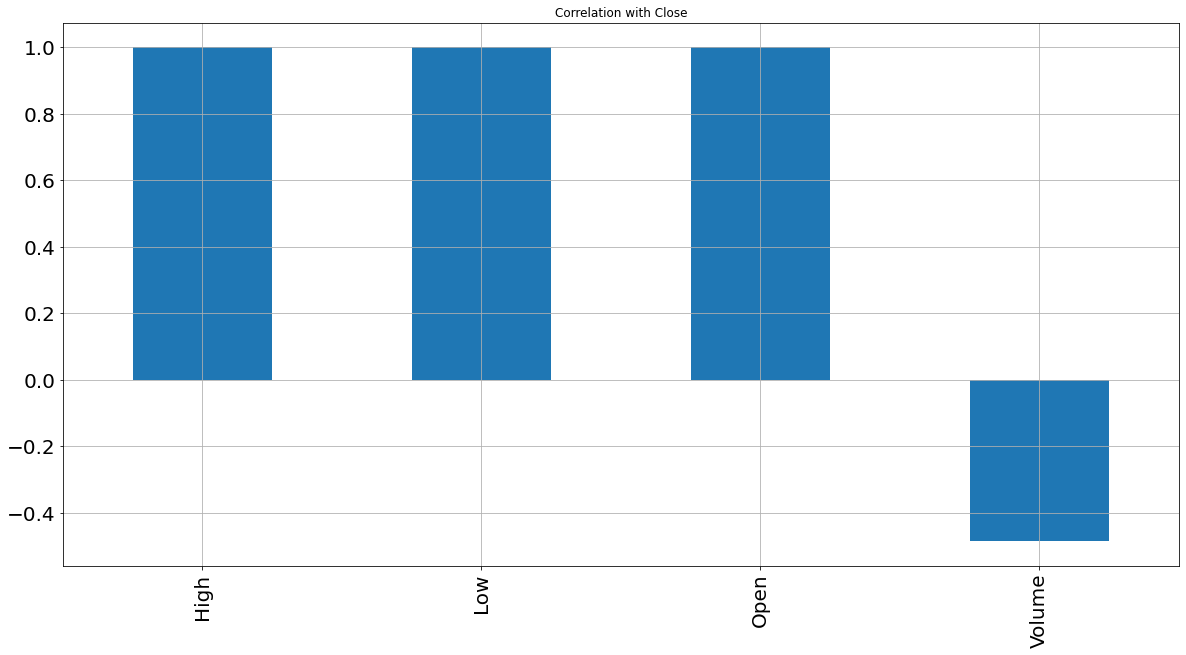

In [ ]:
X.corrwith(df['Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Close", fontsize = 20,
        rot = 90, grid = True)

In [ ]:
test = df
# Target column
target_close = pd.DataFrame(test['Close'])
display(test.head())

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


In [ ]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

**Normalizing the data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2012-01-03,0.010214,0.006095,0.011529,0.175791
2012-01-04,0.010500,0.007125,0.011665,0.146901
2012-01-05,0.012859,0.008953,0.013300,0.154601
2012-01-06,0.015157,0.010937,0.016460,0.186794
2012-01-09,0.017888,0.013300,0.017487,0.238641


In [ ]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_close = target_close.shift(-1)
validation_y = target_close[-90:-1]
target_close = target_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_close.shape)
display(target_close.tail())

,Open,High,Low,Volume
Date,,,,
2012-01-03,0.010214,0.006095,0.011529,0.175791
2012-01-04,0.010500,0.007125,0.011665,0.146901
2012-01-05,0.012859,0.008953,0.013300,0.154601
2012-01-06,0.015157,0.010937,0.016460,0.186794
2012-01-09,0.017888,0.013300,0.017487,0.238641


Shape of features :  (2131, 4)
Shape of target :  (2131, 1)


,Open,High,Low,Volume
Date,,,,
2020-06-15,0.926933,0.954427,0.937292,0.063916
2020-06-16,0.987689,0.979297,0.978287,0.082141
2020-06-17,1.000000,0.986573,0.999797,0.047019
2020-06-18,0.987522,0.980124,0.993483,0.035170
2020-06-19,0.998299,0.990409,0.979739,0.149950


,Close
Date,
2020-06-15,352.079987
2020-06-16,351.589996
2020-06-17,351.730011
2020-06-18,349.720001
2020-06-19,358.869995



 -----After process------ 

Shape of features :  (2041, 4)
Shape of target :  (2041, 1)


,Close
Date,
2020-02-06,320.029999
2020-02-07,321.549988
2020-02-10,319.609985
2020-02-11,327.200012
2020-02-12,324.869995


**Train test Split using Timeseriessplit**

In [ ]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_close[:len(train_index)].values.ravel(), target_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print('Shape of X_train :', X_train.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of X_test :', X_test.shape)
print('Shape of y_test :', y_test.shape)

Shape of X_train : (1856, 4)
Shape of y_train : (1856,)
Shape of X_test : (185, 4)
Shape of y_test : (185,)


 **Benchmark Model**

1.   Linear Regression
2.   SVR Regressor
3.   Randomforest Regressor
4.   Decision Tree


**1.   Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

LinReg = LinearRegression()
LinReg.fit(X_train,y_train)

print("R2 of Linear Regresson:", LinReg.score(X_train,y_train) )
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, LinReg.predict(X_test))))

R2 of Linear Regresson: 0.997630801150841
RMSE: 3.9917800286468044


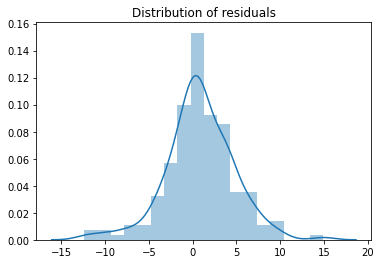

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - LinReg.predict(X_test))
plt.title('Distribution of residuals');

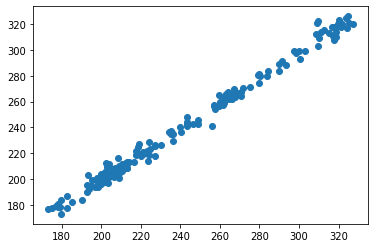

In [ ]:
plt.scatter(y_test,LinReg.predict(X_test))

2. SVR Regressor Model

In [ ]:
from sklearn.svm import SVR

# First, let's choose which kernel is the best for our data

for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_train, y_train)
    print(k,confidence)

linear 0.9966415904399969
poly 0.8080364119951282
rbf 0.9868728241783823
sigmoid -4.879299239408818


In [ ]:
Svr=SVR(kernel='rbf', C=1, gamma= 0.5)   # Parameter Tuning to get the best accuracy

Svr.fit(X_train,y_train)

print("R2 of Linear Regresson:", Svr.score(X_train,y_train) )
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, Svr.predict(X_test))))

R2 of Linear Regresson: 0.9932086345818785
RMSE: 38.1348119988836


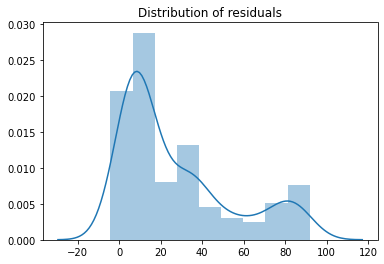

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - Svr.predict(X_test))
plt.title('Distribution of residuals');

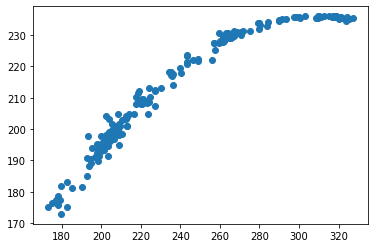

In [ ]:
plt.scatter(y_test,Svr.predict(X_test))

**4. Randomforest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RForest = RandomForestRegressor()
RForest.fit(X_train,y_train)
print("R2 of Linear Regresson:", RForest.score(X_train,y_train) )
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, RForest.predict(X_test))))

R2 of Linear Regresson: 0.9995640742978333
RMSE: 41.23747665617005


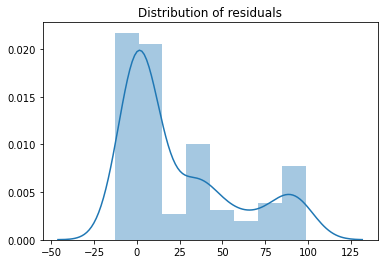

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - RForest.predict(X_test))
plt.title('Distribution of residuals');

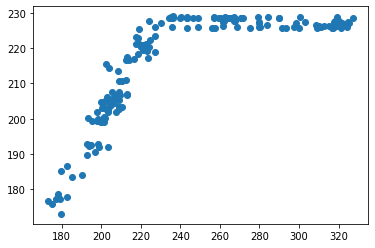

In [ ]:
plt.scatter(y_test,RForest.predict(X_test))

**4. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

print("R2 of Linear Regresson:", dt.score(X_train,y_train) )
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, dt.predict(X_test))))

R2 of Linear Regresson: 1.0
RMSE: 41.54591826398387


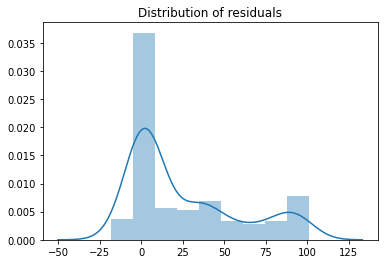

In [ ]:
# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(y_test - dt.predict(X_test))
plt.title('Distribution of residuals');

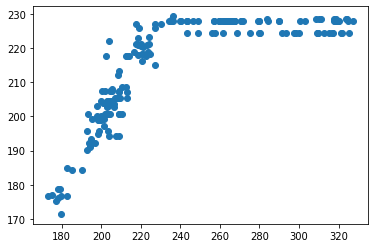

In [ ]:
plt.scatter(y_test,dt.predict(X_test))

**Process the data for LSTM**

In [ ]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


**Model building : LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1856/1856 [==============================] - 2s 1ms/step - loss: 15678.6307
Epoch 2/200
1856/1856 [==============================] - 2s 850us/step - loss: 14973.2918
Epoch 3/200
1856/1856 [==============================] - 2s 839us/step - loss: 13611.6301
Epoch 4/200
1856/1856 [==============================] - 2s 862us/step - loss: 11691.3391
Epoch 5/200
1856/1856 [==============================] - 2s 864us/step - loss: 9515.6230
Epoch 6/200
1856/1856 [==============================] - 2s 846us/step - loss: 7364.7810
Epoch 7/200
1856/1856 [==============================] - 2s 841us/step - loss: 5430.6242
Epoch 8/200
1856/1856 [==============================] - 2s 850us/step - loss: 3822.2294
Epoch 9/200
1856/1856 [==============================] - 2s 857us/step - loss: 2581.3317
Epoch 10/200
1856/1856 [==============================] - 2s 827us/step - loss: 1695.9067
Epoch 11/200
1856/1856 [==============================] - 2s 861us/step - loss: 1114.3610
Epoch 12/200
1856

**Evaluation of Model**

In [ ]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.997
The R2 score on the Test set is:	0.966


**Predictions made by LSTM**

In [ ]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

185/185 [==============================] - 0s 2ms/step


In [ ]:
print('LSTM: %f'%score_lstm)

LSTM: 64.226404


In [ ]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

**LSTM's Prediction Visual**

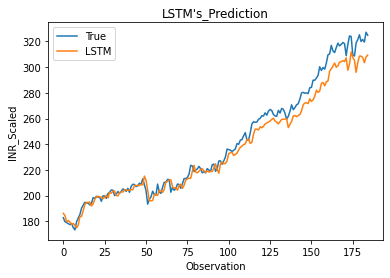

In [ ]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [ ]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'])
results = pd.concat([col1, col2], axis=1)
results.to_csv('PredictionResults_LSTM_NonShift.csv')

In [ ]:
results.head()

,True,LSTM_prediction
0,182.779999,186.176727
1,179.660004,184.497421
2,178.970001,179.608505
3,178.229996,180.657272
4,177.380005,179.463577


**Note:** we can improve the model's accuracy by increasing the epochs, trying out different activation functions or even change the model's structure. 